In [1]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, peak_local_max
from scipy.spatial.distance import cdist
from skimage.transform import AffineTransform, warp
import random

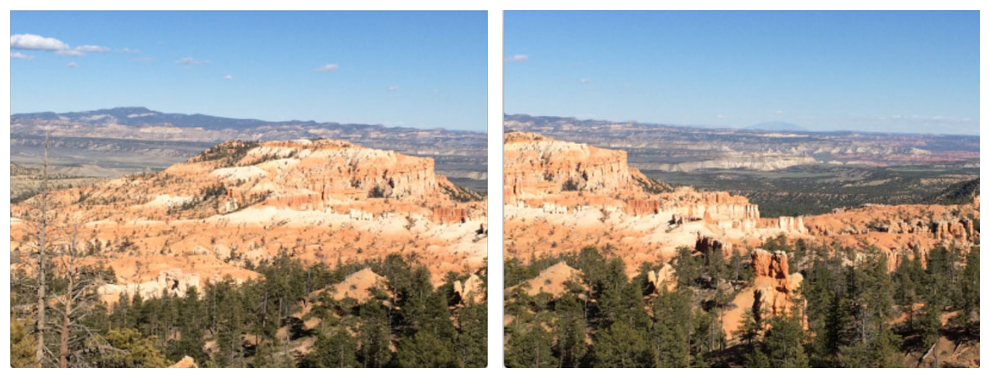

In [2]:
# Visualize the input images after loading and basic processing 
left_img = cv2.imread('./img/mountainleft.png')
right_img = cv2.imread('./img/mountainright.png')

left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(left_img)
ax[1].imshow(right_img)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()


## Step 1: Feature extraction 

##### (a) Find locations of Harris corners after non-maximum supression

In [3]:
def get_corner_patches(img, patch_size=11, min_distance=10, threshold=0.04):
    '''Returns location of maximum Harris corners and fixed-size patches around them'''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Harris corner detection expects grayscale input 
    
    response = corner_harris(gray) # Find the coordinates of Harris corners
    coords = peak_local_max(response, min_distance=min_distance, threshold_rel=threshold, exclude_border=True) # Remove all points that are not 30% of local maxima
    half_size = patch_size // 2 # Traverse half on both sides of the center pixel 

    patches = []
    for y, x in coords:
        if (x >= half_size and y >= half_size and x < gray.shape[1] - half_size and y < gray.shape[0] - half_size): # Ensure that the patch is within the image bounds
            patch = gray[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
            patches.append(patch.flatten())
    patches = np.array(patches)
    return np.array(coords), patches

left_coords, left_patches = get_corner_patches(left_img, patch_size=11, min_distance=10, threshold=0.04)
right_coords, right_patches = get_corner_patches(right_img, patch_size=11, min_distance=10, threshold=0.04)

print(f"One maxima from the left half is located at {left_coords[0]}")

One maxima from the left half is located at [323 193]


##### (b) Visualize the descriptors as a function of patch size (image in appendix) and study variation in number of keypoints as a function of patch size

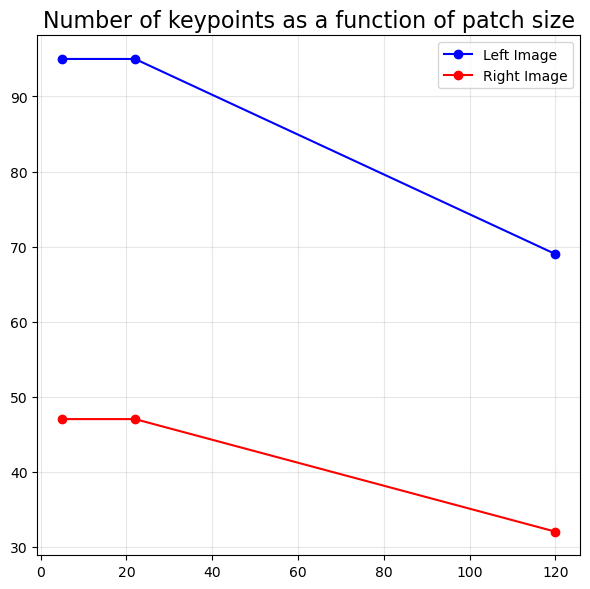

In [4]:
def visualize_patches_and_counts(left_img, right_img, patch_sizes=[5, 11, 22, 120], min_distance=10):
    '''Visualize corner patches on images and plot patch counts vs patch size.'''
    left_counts = []
    right_counts = []
   
    fig_patches = plt.figure(figsize=(12, 4 * len(patch_sizes)))
   
    # For each patch size get the corners and patches
    for i, patch in enumerate(patch_sizes):
        left_coords, left_patches = get_corner_patches(left_img, patch_size=patch, min_distance=min_distance)
        right_coords, right_patches = get_corner_patches(right_img, patch_size=patch, min_distance=min_distance)
       
        # Store counts for the line chart
        left_counts.append(len(left_patches))
        right_counts.append(len(right_patches))
    
        left_img_rgb = left_img.copy()
        right_img_rgb = right_img.copy()
       
        ax1 = fig_patches.add_subplot(len(patch_sizes), 2, 2*i + 1)
        ax1.imshow(cv2.cvtColor(left_img_rgb, cv2.COLOR_BGR2RGB))
        ax1.set_title(f"Left Image - Patch Size: {patch} - {len(left_patches)} patches")
        
        # Plot corner boundaries
        if len(left_coords) > 0:
            y_coords, x_coords = zip(*left_coords)
            ax1.scatter(x_coords, y_coords, c='r', s=10)
            
            for y, x in left_coords:
                half_patch = patch // 2
                rect = plt.Rectangle((x - half_patch, y - half_patch), 
                                    patch, patch, 
                                    linewidth=1, edgecolor='r', facecolor='none')
                ax1.add_patch(rect)
        
        ax1.axis('off')
    
        ax2 = fig_patches.add_subplot(len(patch_sizes), 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(right_img_rgb, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Right Image - Patch Size: {patch} - {len(right_patches)} patches")
        
        # Plot corner boundaries
        if len(right_coords) > 0:
            y_coords, x_coords = zip(*right_coords)
            ax2.scatter(x_coords, y_coords, c='r', s=10)
    
            for y, x in right_coords:
                half_patch = patch // 2
                rect = plt.Rectangle((x - half_patch, y - half_patch), 
                                    patch, patch, 
                                    linewidth=1, edgecolor='r', facecolor='none')
                ax2.add_patch(rect)
        
        ax2.axis('off')
   
    plt.tight_layout()
    plt.savefig('Different patch sizes visualized.png')
    plt.close()
   
    # Plot the number of keypoints as a function of patch size
    plt.figure(figsize=(6, 6))
    plt.plot(patch_sizes, left_counts, 'bo-', label='Left Image')
    plt.plot(patch_sizes, right_counts, 'ro-', label='Right Image')
    plt.title('Number of keypoints as a function of patch size', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('n of keypoints =f(patch size).png')
    plt.show()

patches = [5, 22, 120]
visualize_patches_and_counts(left_img, right_img, patch_sizes=patches)

##### (c) Create SIFT descriptors at the Harris corner keypoint locations and normalize them

In [5]:
sift = cv2.SIFT_create() 

left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# Use same keypoints as before 
left_keypoints_sift = [cv2.KeyPoint(float(x), float(y), size=11) for y, x in left_coords]
right_keypoints_sift = [cv2.KeyPoint(float(x), float(y), size=11) for y, x in right_coords]

# Compute sift descriptors around the keypoints 
_, left_descriptors = sift.compute(left_gray, left_keypoints_sift)
_, right_descriptors = sift.compute(right_gray, right_keypoints_sift)

# Normalize descriptors 
norms_left = np.linalg.norm(left_descriptors, axis=1, keepdims=True)
norms_right = np.linalg.norm(right_descriptors, axis=1, keepdims=True)

left_descriptors = left_descriptors / norms_left
right_descriptors = right_descriptors / norms_right

## Step 2: Feature matching

##### Distance metrics considered 

(i) Euclidean: $\sqrt{(v^{2}-u^{2})}$

(ii) Normalized correlation:  $ 1 - \frac{(\mathbf{u} - \bar{\mathbf{u}}) \cdot (\mathbf{v} - \bar{\mathbf{v}})}{\| \mathbf{u} - \bar{\mathbf{u}} \|_2 \, \| \mathbf{v} - \bar{\mathbf{v}} \|_2}$

In [6]:
def match_descriptors(desc1, desc2, method='euclidean'):
    '''Matches descriptors from two images using specified metric. Returns a sorted list of matches in the form (index1, index2, distance)'''
    if method == 'euclidean':
        dists = cdist(desc1, desc2, metric='euclidean') # Lower the better 
    elif method == 'correlation':
        dists = -cdist(desc1, desc2, metric='correlation') # Higher the better

    matches = []
    for i in range(dists.shape[0]):
        j = np.argmin(dists[i])
        matches.append((i, j, dists[i][j]))

    return sorted(matches, key=lambda x: x[2])

matches_euclidean = match_descriptors(left_descriptors, right_descriptors, method='euclidean')
matches_correlation = match_descriptors(left_descriptors, right_descriptors, method='correlation')

print(f"The first few matches using euclidean distance are: {matches_euclidean[:2]}")
print(f"The first few matches using correlation distance are: {matches_correlation[:2]}")

The first few matches using euclidean distance are: [(2, np.int64(6), np.float64(0.041413312022285695)), (12, np.int64(24), np.float64(0.04446421276637669))]
The first few matches using correlation distance are: [(66, np.int64(45), np.float64(-1.4041597677433137)), (38, np.int64(45), np.float64(-1.3728611283960521))]


##### (a) Plot the two different sets of matched features

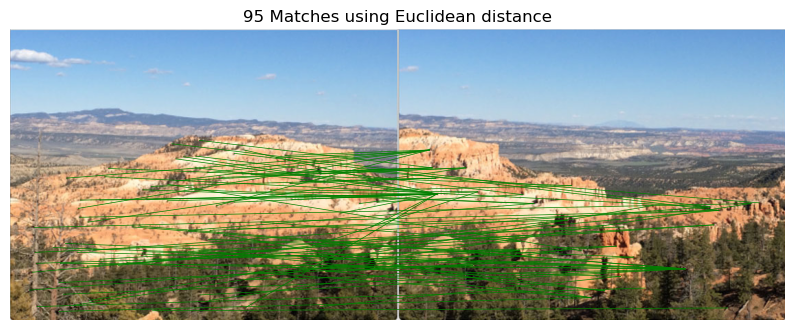

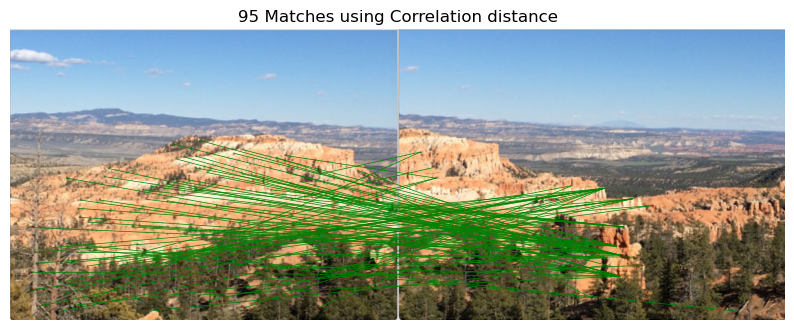

In [7]:
def plot_matches(img1, img2, kp1, kp2, matches, metric):
    '''Plot matched keypoints and a line joining them between the two images'''
    h1, w1 = img1.shape[:2]
    plt.figure(figsize=(10, 5))
    img_combined = np.hstack((img1, img2))
    plt.imshow(img_combined)
    for i, j, in matches:  # Unpack only the first two elements (index1, index2)
        pt1 = kp1[i][::-1]
        pt2 = (kp2[j][1] + w1, kp2[j][0])
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g-', linewidth=0.5)
    plt.title(f'{len(matches)} Matches using {metric} distance') 
    plt.axis('off')

best_matches_euclidean = matches_euclidean[:100]
best_matches_filtered = [(i,j) for i,j,_ in best_matches_euclidean]
plot_matches(left_img, right_img, left_coords, right_coords, best_matches_filtered, metric='Euclidean')

best_matches_correlation = matches_correlation[:100]
best_matches_filtered = [(i,j) for i,j,_ in best_matches_correlation]
plot_matches(left_img, right_img, left_coords, right_coords, best_matches_filtered, metric='Correlation')


Notice that the matches made are between different keypoints for each type of metric.

## Step 3: RANSAC

##### (a) Custom Implementation

In [8]:
def ransac_affine(kp1, kp2, matches, n_iter=1000, threshold=5, match=3):
    '''Returns the best affine transformation, inliers and residual error after random sampling'''
    best_inliers = [] # Store the best inliers and the best transformation
    best_model = None
    for _ in range(n_iter): # Pick a transformation n_iter times 
        sample = random.sample(matches, match) # Randomly select 3 matches to estimate A 
        pts1 = np.float32([kp1[i] for i, _, _ in sample])
        pts2 = np.float32([kp2[j] for _, j, _ in sample])
        model = AffineTransform()
        model.estimate(pts2[:, ::-1], pts1[:, ::-1]) # Solve Ax = b using least squares
        inliers = []
        for i, j, _ in matches:
            p1 = np.array(kp1[i])[::-1]
            p2 = np.array(kp2[j])[::-1]
            if np.linalg.norm(p1 - model(p2)) < threshold: # If point lies inside threshold, it is an inlier 
                inliers.append((i, j))
        if len(inliers) > len(best_inliers): # Update best models if current iteration has more inliers  
            best_inliers = inliers
            best_model = model

    # Calculate Euclidean residual error
    if best_model and best_inliers:
        errors = []
        for i, j in best_inliers: # For every inlier 
            p1 = np.array(kp1[i])[::-1]
            p2 = np.array(kp2[j])[::-1]
            transformed_p2 = best_model(p2) # Make prediction A'x = b'
            error = np.linalg.norm(p1 - transformed_p2) # Compare against truth, Ax = b
            errors.append(error)
        residual_error = np.mean(errors)
    else:
        residual_error = float('inf')
    
    n_outliers = len(matches) - len(best_inliers) # Each matched point is either an inlier or an outlier 

    return best_model, best_inliers, residual_error, n_outliers

In [9]:
best_model, best_inliers, residual_error, n_outliers = ransac_affine(left_coords, right_coords, best_matches_euclidean, n_iter=1000, threshold=5)

print(f"Transformation Matrix: {best_model}")
print(f"Number of inliers: {len(best_inliers)}")
print(f"Number of outliers: {n_outliers}")
print(f"Residual error: {residual_error:.2f}")

Transformation Matrix: <AffineTransform(matrix=
    [[ 1.01587862e+00, -3.67854622e-02,  3.60886644e+02],
     [ 3.14043754e-02,  9.93913197e-01,  7.66469654e+00],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])>
Number of inliers: 12
Number of outliers: 83
Residual error: 1.47


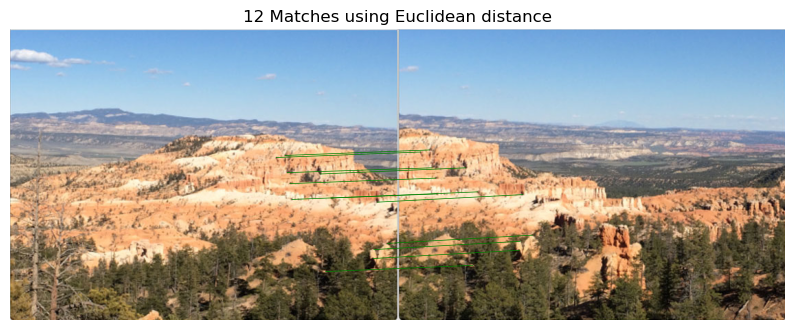

In [10]:
plot_matches(left_img, right_img, left_coords, right_coords, best_inliers, metric='Euclidean')

## Step 4: Image stitching

In [11]:
def stitch_images(img1, img2, transform):
    '''Stitches img2 onto img1 by applying given transform.'''
    output_shape = (img1.shape[0], img1.shape[1] + img2.shape[1])
    warped = warp(img2, transform.inverse, output_shape=output_shape)
    result = np.copy(warped)
    result[0:img1.shape[0], 0:img1.shape[1]] = img1 / 255.0
    return result

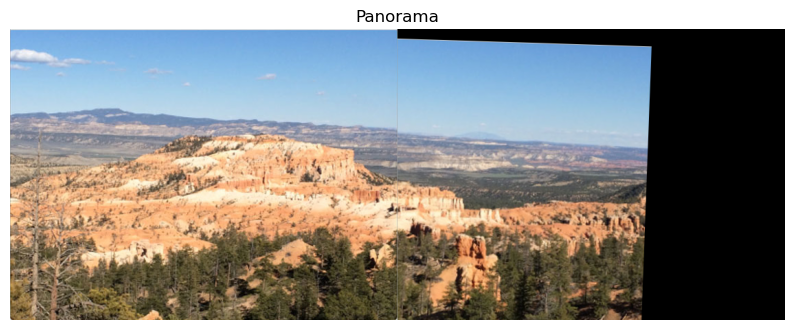

In [12]:
final_image = stitch_images(left_img, right_img, best_model)
plt.figure(figsize=(10, 5))
plt.imshow(final_image);
plt.title("Panorama");
plt.axis('off');

## Step 5: Sensitivity Analysis

##### (a) Distance metric, number of matches and residual error

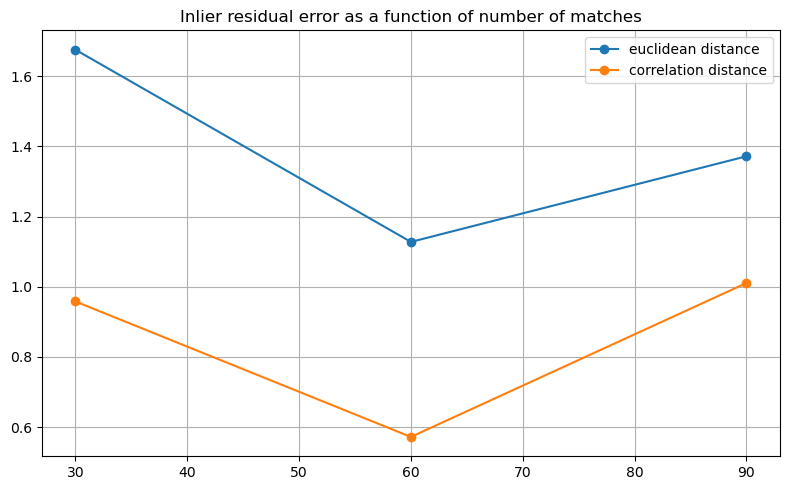

In [13]:
def evaluate_match_subset_sizes(desc1, desc2, kp1, kp2, match_counts=[30, 60, 90]):
    '''Evaluates RANSAC residual error for varying match subset sizes and plots results'''
    metrics = ['euclidean', 'correlation']
    results = {metric: [] for metric in metrics}

    for metric in metrics:
        matches = match_descriptors(desc1, desc2, method=metric)

        for count in match_counts:
            top_matches = matches[:count]
            model, inliers, residual_error, n_outliers = ransac_affine(kp1, kp2, top_matches)
            results[metric].append(residual_error)

    # Plotting results
    plt.figure(figsize=(8, 5))
    for metric in metrics:
        plt.plot(match_counts, results[metric], marker='o', label=f'{metric} distance')

    plt.title('Inlier residual error as a function of number of matches')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_match_subset_sizes(left_descriptors, right_descriptors, left_coords, right_coords, match_counts=[30, 60, 90])

##### (c) Number of iterations and residual error

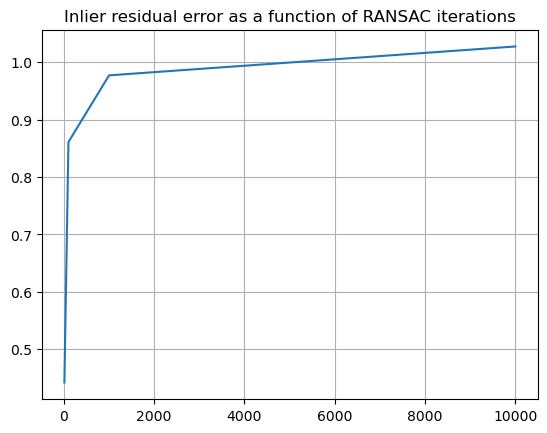

In [14]:
iterations = [10, 100, 1000, 10000]
errors = []

for n_iter in iterations:
    model, inliers, residual_error, n_outliers = ransac_affine(left_coords, right_coords, matches_euclidean, n_iter=n_iter, threshold=5)
    errors.append(residual_error)

plt.plot(iterations, errors)
plt.title('Inlier residual error as a function of RANSAC iterations')
plt.grid(True)
plt.show()

##### (d) Inlier threshold and residual error

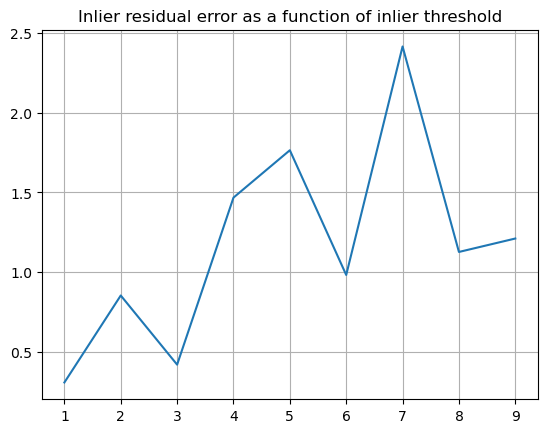

In [15]:
thresholds = range(1, 10)
errors = []

for t in thresholds:
    _, _, error, _ = ransac_affine(left_coords, right_coords, best_matches_euclidean, threshold=t)
    errors.append(error)

plt.plot(thresholds, errors)
plt.title("Inlier residual error as a function of inlier threshold")
plt.grid(True)
plt.show()

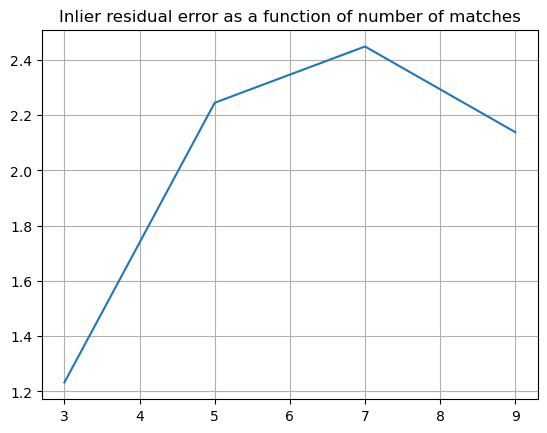

In [17]:
matches = [3, 5, 7, 9]
errors = []

for match in matches:
    _, _, error, _ = ransac_affine(left_coords, right_coords, best_matches_euclidean, match=match)
    errors.append(error)

plt.plot(matches, errors)
plt.title("Inlier residual error as a function of number of matches")
plt.grid(True)
plt.show()